In [2]:
%matplotlib
import numpy as np
from scipy import integrate
from scipy.special import gamma
from scipy.optimize import fsolve, basinhopping
import matplotlib.pyplot as plt
import qutip.ipynbtools
from ipywidgets import FloatProgress
import qutip.parallel
from scipy import signal
import scipy.io
import gc
import matplotlib.colors as colors
from IPython.display import clear_output, Javascript, Markdown
import datetime
import math
import uuid
import os
import time
import ipyparallel
import qutip.ui
import random
import signal
matplotlib.pyplot.switch_backend('nbAgg')

Using matplotlib backend: GTK3Agg


In [125]:
gcoll = 44.8#2*9.5*np.pi #HWHM
q = 1.39
quali = 230#892
fr = 3.4892e3;
kappa = np.pi*fr/quali #HWHM
deltas = 20 #detuning spins as a frequency- cavity ws-wc
deltac = 0*2*np.pi
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*10#0.001 #HWHM
gammaq = 2*np.pi*4#9.4 #FWHM
nbins = 1#701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

47.65932646480655


In [126]:
def tsallis(f, q, width):
    delta = (width)/2*np.sqrt(2*q-2)/np.sqrt(2**q-2)/np.sqrt(2)
    norm = np.sqrt(q-1)*gamma(1/(q-1))/(np.sqrt(2*np.pi)*delta*gamma((3-q)/(2*(q-1))))
    val = (1+(q-1)*f**2/delta**2/2)**(1/(1-q))
    return norm*val

In [127]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

def find_nearest_sorted(array,value):
    """much faster for sorted arrays"""
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def cauchy(x, pos, fwhm, ampl):
    return 1/((x-pos)**2+0.25*fwhm**2)*0.25*fwhm**2*ampl


In [128]:
holes = False #set to true if you want to include holes in your simulation
inhomo = True #do you want inhomogneous broadening

if nbins != 1:
    f = np.linspace(-gammaq/2, gammaq/2, nbins )
else:
    f = np.array([0])
pdf = tsallis(f, q, gammaq/2/np.pi)


if holes:
    frequency_exclude = gcoll/2/np.pi
    exclude_width = 0.2 #FWHM

    indf, freq = find_nearest(f, frequency_exclude)
    scale = pdf[indf]

    toex = cauchy(f, frequency_exclude, exclude_width, -scale)+cauchy(f, -frequency_exclude, exclude_width, -scale)
    #toex2 = cauchy(f, 0, exclude_width, -pdf[int(len(f)/2)])
    pdf = pdf+toex

pdf = np.clip(pdf, 0, max(pdf) )   
    
spdf = sum(pdf)
pdf = pdf/spdf    

if not inhomo:
    pdf = np.zeros(np.shape(pdf))
    pdf[int(nbins/2)] = 1
    
spins = f+deltas #draw samples according to distribution, they are detuned from, that is only true if deltac is equal to zero
gs = np.sqrt(pdf)*gcoll
plt.plot(f, pdf)
#%qtconsole

In [129]:
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = integrate.odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z
    
def rootz(func, z0, **kwargs):
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)
    def realfunc(x, *args):
        z = x.view(np.complex128)
        dzdt = func(z, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = scipy.optimize.root(realfunc, z0.view(np.float64), **kwargs)
    if not result.success:
        print('Finding the root was not successfull')
        print(result.message)
    z = result.x.view(np.complex128)
    return z

In [130]:

def mbes_steady_without_a(Y, a):
    ret = np.zeros(nbins*2, dtype=np.complex128)
    ret[::2] = -(gperp+gpar/2 + 1j*(spins*2*np.pi+deltac))*Y[::2]+gs*Y[1::2]*a
    ret[1::2] = -gpar*(1+Y[1::2])-2*gs*(Y[::2]*np.conj(a)+np.conj(Y[::2])*a)
    return ret

def mbes_only_a(Y, eta, deltdrive, g=None):
    if g is None:
        g = gs
    spins2 = 2*np.pi*(spins)+deltdrive

    s1 = 2*Y*g**2*gpar
    s2 = gpar+2*gperp+2*1j*spins2
    s3 = 8*(gpar+2*gperp)*np.abs(Y)**2*g**2
    s4 = gpar*((gpar+2*gperp)**2+4*spins2**2)
    
    s = s1*s2/(s3+s4)

       
    ret = -1j*Y*deltdrive + eta - Y*kappa - np.sum(s)
    return ret

def mbes(Y, t, eta):
    ret = np.zeros(nbins*2+1, dtype=np.complex128)
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+np.sum(gs*Y[1::2])+eta
    ret[1::2] = -(gperp+gpar/2 + 1j*(spins*2*np.pi+deltac))*Y[1::2]+gs*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*gs*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret



<IPython.core.display.Javascript object>


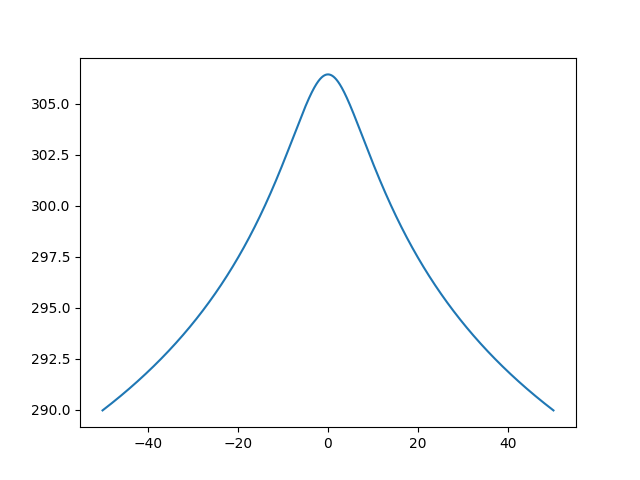

In [131]:
initsteady = (1,1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 8000) #equals wc-wp
etasteady = 10e16
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady[0]*etasteady +1j*initsteady[1]*etasteady
for i, delt in enumerate(deltaarr):
    ar = rootz(mbes_only_a, newinit, args=(etasteady, delt) )
    newinit = ar
    losasteady[i] = abs(ar)**2
    losareal[i] = ar.real
    losaimag[i] = ar.imag

fig = plt.figure()
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [132]:
drivearr = np.logspace(-20,20,1601)
fresarr = np.zeros(np.shape(drivearr))
dummydeltaarr = [0]
for j, drive in enumerate(drivearr):
    newinit = initsteady[0]*drive +1j*initsteady[1]*drive
    maxa = 0
    fres = 0
    for i, delt in enumerate(dummydeltaarr):
        ar = rootz(mbes_only_a, newinit, args=(drive, delt) )
        newinit = ar
        losa = abs(ar)**2
        if losa > maxa:
            maxa = losa
            fres = delt
        else:
            break
    fresarr[j] = sqrt(losa)/drive

<IPython.core.display.Javascript object>


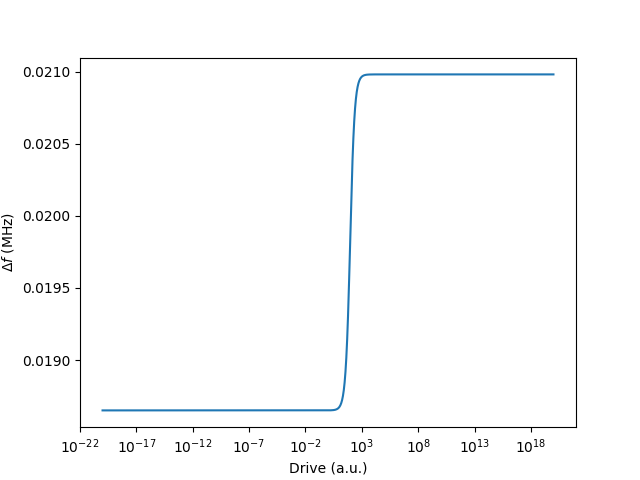

In [133]:
plt.figure()
plt.semilogx(drivearr, fresarr)
plt.xlabel('Drive (a.u.)')
plt.ylabel('$\Delta f$ (MHz)');

In [106]:
def do_calculation_decay(tlist, init):
    #this should be very fast as well because scipy uses fortran 
    asol, infodict = odeintz(mbes, init, tlist, args=(0,), full_output=True)
    
    #this is necessary because we are clustering the spins

    asol[:,2::2] = asol[:,2::2]*pdf
    asol[:,1::2] = asol[:,1::2]*pdf
    return asol, infodict
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

In [134]:
idx = 1600
eta = drivearr[idx]
astart = rootz(mbes_only_a, fresarr[idx]*eta, args=(eta, 0) )

init = np.zeros((nbins*2+1)) #steady state after driving is zero
init = np.asarray(init, dtype=complex)
init[1::2] = 1e-13
init[2::2] = 0*1e-26
init[0] = astart

initspins = rootz(mbes_steady_without_a, init[1:], args=(astart))

init[1:] = initspins
initspins = rootz(mbes_steady_without_a, init[1:], args=(astart))

init[1:] = initspins
sol = rootz(mbes, init, args=(0, eta))

Finding the root was not successfull
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


In [140]:
dt = 0.01e-3
tlistdecay = np.arange(0, 3*50e-3+dt, dt)
asol, infodict = do_calculation_decay(tlistdecay, sol)

/usr/local/lib/python3.5/dist-packages/scipy/integrate/odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


<IPython.core.display.Javascript object>


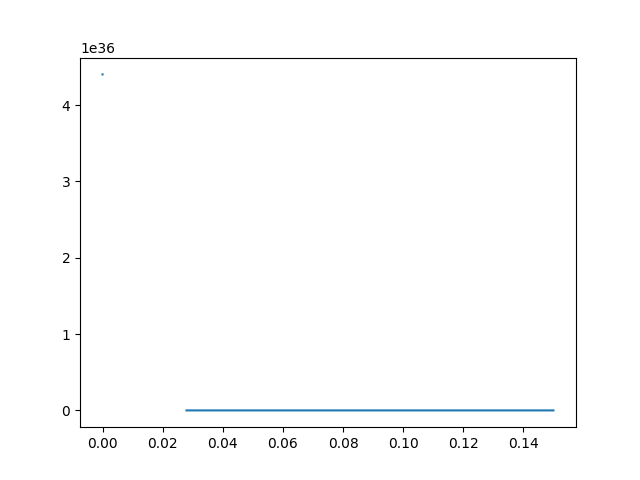

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


In [141]:
plt.figure()
plt.plot(tlistdecay, abs(asol[:,0])**2)
#plt.plot(tlistdecay, np.real(np.sum(asol[:,2::2], axis=1)))